# Case 2 - Exploration

## 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd

# Imputers
from sklearn.impute import KNNImputer, SimpleImputer

# Standardization scalers
from sklearn.preprocessing import StandardScaler

# Splitting data
from sklearn.model_selection import train_test_split

# Set seed for reproducibility
import random
random.seed(42)


#For clustering
# --- Import libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

## 2. Loading Data

A 312x67 datamatrix. Orginally 312x68 in the csv but the first column was the index column

In [2]:
# Path to the data files
data_path = '../../case2/HR_data.csv'


# Create a pandas dataframe and use the first row as the column names
data_pd = pd.read_csv(data_path, sep=',', header=0)
#remove the first column and reorder so the non numeric columns are the first
data_pd = data_pd.iloc[:, 1:]


#Moving identufyer columns up
id_columns = ['Round', 'Phase', 'Individual','Puzzler', 'Cohort']
numeric_columns = [col for col in data_pd.columns if col not in id_columns]
data_pd = data_pd[id_columns + numeric_columns]
# 
# Print the shape of the data in the pandas dataframe
print("The shape of the data")
print(data_pd.shape)


The shape of the data
(312, 67)


## 3. Data cleaning & visualisation

### Missing values:

In [3]:
# Shows count of NaNs per column
na_summary = data_pd.isna().sum()
# Display only columns with at least 1 NaN (optional)
na_summary = na_summary[na_summary > 0]
print(na_summary)


EDA_TD_P_RT     1
EDA_TD_P_ReT    1
inspired        2
attentive       1
afraid          1
active          1
determined      2
dtype: int64


- Filling missing values in questionaries columns by impuding with the most common value for individuals in that phase
- Filling missing values in the biometric data columns with mean

In [4]:
q_cols = ['Frustrated', 'upset', 'hostile',
       'alert', 'ashamed', 'inspired', 'nervous', 'attentive', 'afraid',
       'active', 'determined']
#Filling missing values in questionaire columns 
data_pd[q_cols] = data_pd.groupby('Phase')[q_cols].transform(lambda x: x.fillna(x.mode().iloc[0]))

#Filling the missin
data_pd.fillna({col: data_pd[col].mean() for col in ['EDA_TD_P_RT', 'EDA_TD_P_ReT']}, inplace=True)

biometric_df = data_pd.iloc[:, 5:56]

emotions_df = data_pd.iloc[:, -10:]
emotions_df.columns

Index(['upset', 'hostile', 'alert', 'ashamed', 'inspired', 'nervous',
       'attentive', 'afraid', 'active', 'determined'],
      dtype='object')

In [5]:
data_pd['Cohort']

0      D1_4
1      D1_4
2      D1_4
3      D1_4
4      D1_4
       ... 
307    D1_5
308    D1_5
309    D1_5
310    D1_5
311    D1_5
Name: Cohort, Length: 312, dtype: object

#### 3.1 Boxplots of the emotions in three phases

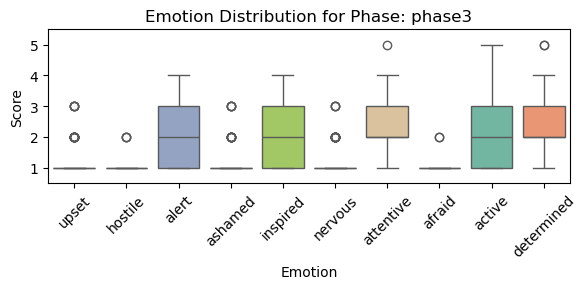

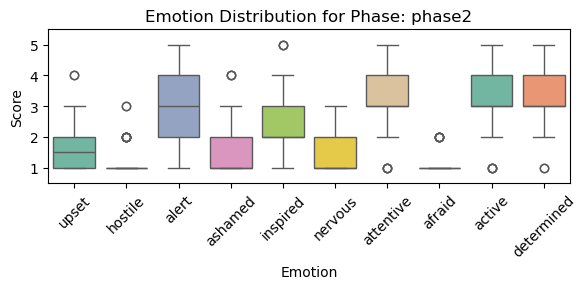

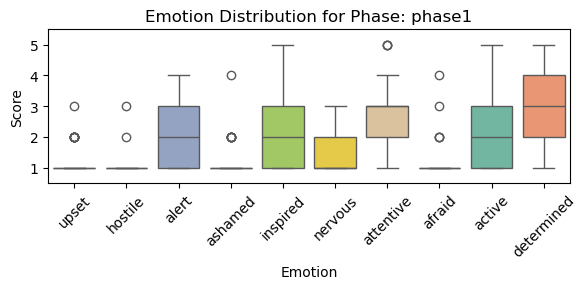

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Emotion column names
emotion_cols = emotions_df.columns

# Define a color palette
palette = sns.color_palette("Set2", len(emotion_cols))

# Combine Phase and Emotions
full_df = data_pd[['Phase']].join(emotions_df)

# Plot one figure per phase
for phase in full_df['Phase'].unique():
    plt.figure(figsize=(6, 3))  # Smaller figure
    phase_data = full_df[full_df['Phase'] == phase]
    
    # Melt the data
    phase_data_melted = phase_data.melt(id_vars='Phase', value_vars=emotion_cols,
                                        var_name='Emotion', value_name='Score')
    
    # Correct boxplot
    sns.boxplot(x='Emotion', y='Score', hue='Emotion', data=phase_data_melted,
                palette=dict(zip(emotion_cols, palette)),
                dodge=False)  # dodge=False to keep boxes together

    plt.title(f'Emotion Distribution for Phase: {phase}')
    plt.xticks(rotation=45)
    plt.ylim(0.5, 5.5)  # Scores from 1 to 5
    plt.xlabel('Emotion')
    plt.ylabel('Score')
    plt.legend([],[], frameon=False)  # Remove legend
    plt.tight_layout()
    plt.show()

#### 3.2 Heatmap of emotions across the three phases

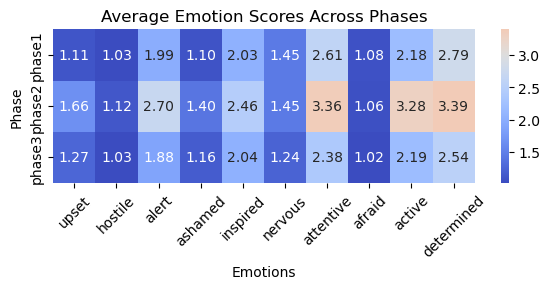

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Emotion columns
emotion_cols = emotions_df.columns

# Combine Phase and Emotions
full_df = data_pd[['Phase']].join(emotions_df)

# Group by Phase and calculate mean scores
emotion_means = full_df.groupby('Phase')[emotion_cols].mean()

# Create the heatmap
plt.figure(figsize=(6, 3))
sns.heatmap(emotion_means, annot=True, fmt=".2f", cmap="coolwarm", center=3)

plt.title('Average Emotion Scores Across Phases')
plt.xlabel('Emotions')
plt.ylabel('Phase')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 4. Explore clustering methods to derive insights from the data.

#### 4.1 Hiearchical clustering of biometric signals

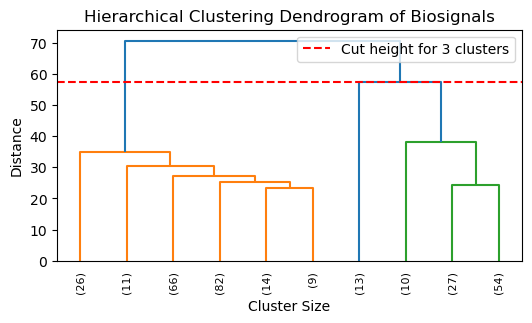

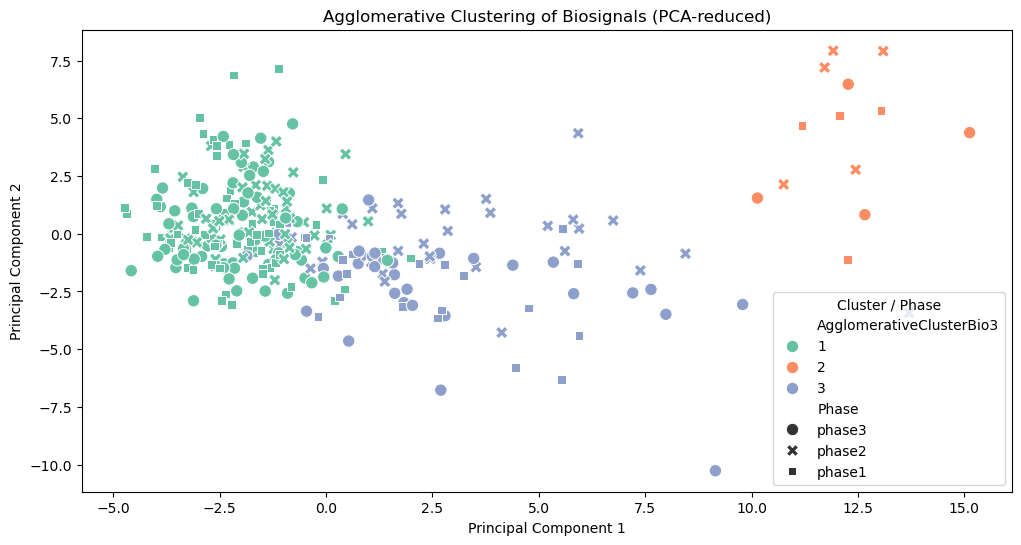

In [8]:
# Create a mapping for the cohort transformation
cohort_map = {
    'D1_1': 'D1_1',
    'D1_2': 'D1_2',
    'D1_3': 'D1_3',
    'D1_4': 'D1_3',
    'D1_5': 'D1_3',
    'D1_6': 'D1_3'
}

# Create new column with transformed cohorts
data_pd['CohortGrouped'] = data_pd['Cohort'].map(cohort_map)
#Make correlation hea

# --- Standardize the biometric features ---
scaler = StandardScaler()
biometric_scaled = scaler.fit_transform(biometric_df)

# --- Perform hierarchical clustering ---
Z = linkage(biometric_scaled, method='ward', metric='euclidean')

# --- Choose number of clusters ---
n_clusters = 3

# --- Find the appropriate height to cut the dendrogram ---
# The distance at which to cut to get `n_clusters`
cut_height = Z[-n_clusters + 1, 2]

# --- Plot dendrogram with horizontal cut line ---
plt.figure(figsize=(6, 3))
plt.title('Hierarchical Clustering Dendrogram of Biosignals')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')

dendrogram(Z, 
           truncate_mode='lastp',
           leaf_rotation=90., 
           leaf_font_size=8., 
           color_threshold=cut_height, 
           p=10)
plt.axhline(y=cut_height, c='red', linestyle='--', label=f'Cut height for {n_clusters} clusters')
plt.legend()
plt.savefig('../plots/dendrogram_biosignals_3_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Optional: Cut the dendrogram to form flat clusters ---
# Here we choose to form 3 clusters (you can change 3 to another number)

cluster_labels = fcluster(Z, t=n_clusters, criterion='maxclust')

# --- Add the cluster labels back to the dataset ---
data_pd['AgglomerativeClusterBio3'] = cluster_labels

# --- (Optional) Visualize clusters using PCA ---
pca = PCA(n_components=2)
pca_components = pca.fit_transform(biometric_scaled)



# Plot
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=pca_components[:, 0],
    y=pca_components[:, 1],
    hue=data_pd['AgglomerativeClusterBio3'],       # color by cluster
    style=data_pd['Phase'],                    # shape by phase
    palette='Set2',
    s=80                                       # optional: size of points
)
plt.title('Agglomerative Clustering of Biosignals (PCA-reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster / Phase')
plt.show()

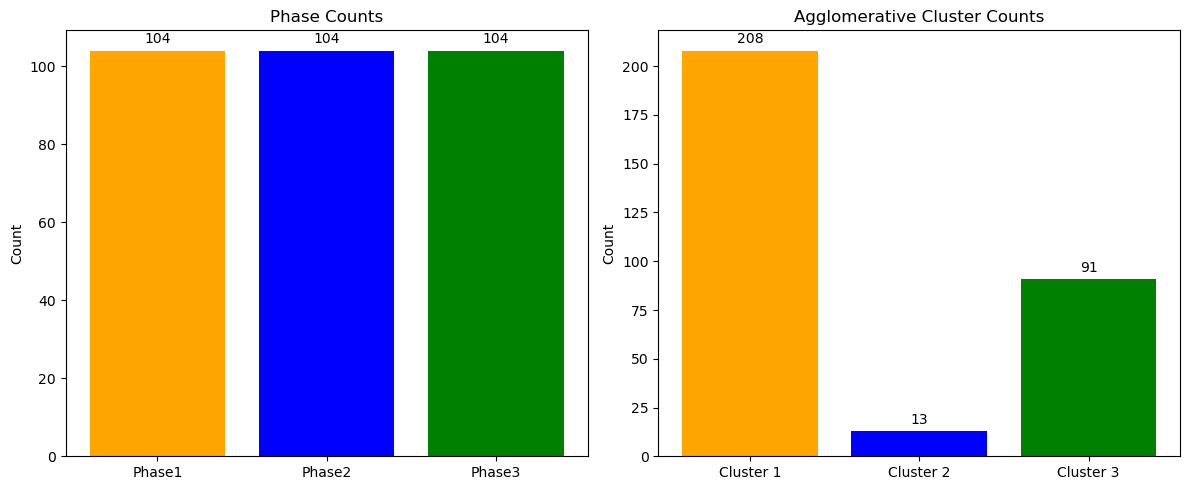

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Phase counts
phase_counts = data_pd['Phase'].value_counts()
phase1_count = phase_counts.get('phase1', 0)
phase2_count = phase_counts.get('phase2', 0)
phase3_count = phase_counts.get('phase3', 0)

# Cluster counts (assuming clusters labeled 1, 2, 3)
cluster_counts = data_pd['AgglomerativeClusterBio3'].value_counts()
cluster0_count = cluster_counts.get(1, 0)
cluster1_count = cluster_counts.get(2, 0)
cluster2_count = cluster_counts.get(3, 0)

# Define colors: orange, blue, green
colors = ['orange', 'blue', 'green']

# Set up side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot phase counts
labels_phase = ['Phase1', 'Phase2', 'Phase3']
values_phase = [phase1_count, phase2_count, phase3_count]

bars1 = ax1.bar(labels_phase, values_phase, color=colors)
ax1.set_title('Phase Counts')
ax1.set_ylabel('Count')

# Annotate phase bars
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')

# Plot cluster counts
labels_cluster = ['Cluster 1', 'Cluster 2', 'Cluster 3']
values_cluster = [cluster0_count, cluster1_count, cluster2_count]

bars2 = ax2.bar(labels_cluster, values_cluster, color=colors)
ax2.set_title('Agglomerative Cluster Counts')
ax2.set_ylabel('Count')

# Annotate cluster bars
for bar in bars2:
    height = bar.get_height()
    ax2.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.tight_layout()
plt.savefig('../plots/3phase_3cluster_counts.png', dpi=300, bbox_inches='tight')
plt.show()


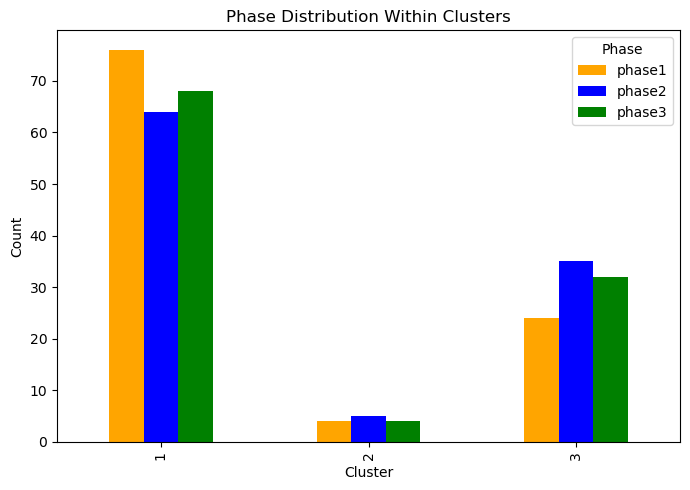

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate phase counts within each cluster
cluster_phase_counts = (
    data_pd.groupby(['AgglomerativeClusterBio3', 'Phase'])
    .size()
    .unstack(fill_value=0)
    .reindex([1, 2, 3], fill_value=0)  # Ensure clusters 1, 2, 3 are in order
)

# Define colors: orange (phase1), blue (phase2), green (phase3)
colors = ['orange', 'blue', 'green']

# Plot phase distribution within clusters (grouped bars)
fig, ax = plt.subplots(figsize=(7, 5))
cluster_phase_counts.plot(kind='bar', ax=ax, color=colors)

ax.set_title('Phase Distribution Within Clusters')
ax.set_xlabel('Cluster')
ax.set_ylabel('Count')
ax.legend(title='Phase')

plt.tight_layout()
plt.savefig('../plots/3phase_3cluster_within_counts.png', dpi=300, bbox_inches='tight')
plt.show()


#### 4.1.1 PCA of biosignals colored by hiearchical clustering of biosignals shapes defined by positve/negative individuals

In [10]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Define emotion categories
positive_emotions = ['active', 'alert', 'attentive', 'determined', 'inspired']
negative_emotions = ['afraid', 'ashamed', 'hostile', 'nervous', 'upset']

# Standardize emotion scores *per column*
scaler = StandardScaler()
emotions_df_scaled = pd.DataFrame(
    scaler.fit_transform(emotions_df),
    columns=emotions_df.columns,
    index=emotions_df.index
)

# Compute means and classify moods
data_pd['Mood'] = np.where(
    emotions_df_scaled[positive_emotions].mean(axis=1) > emotions_df_scaled[negative_emotions].mean(axis=1),
    'positive',
    'negative'
)

# Count unique moods
unique_moods = data_pd['Mood'].unique()
print("Unique moods:")

for mood in unique_moods:
    count = (data_pd['Mood'] == mood).sum()
    print(f"{mood}: {count}")


Unique moods:
negative: 171
positive: 141


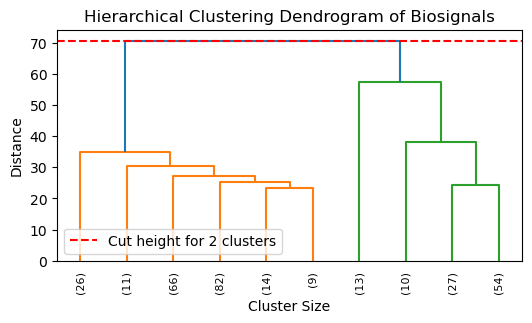

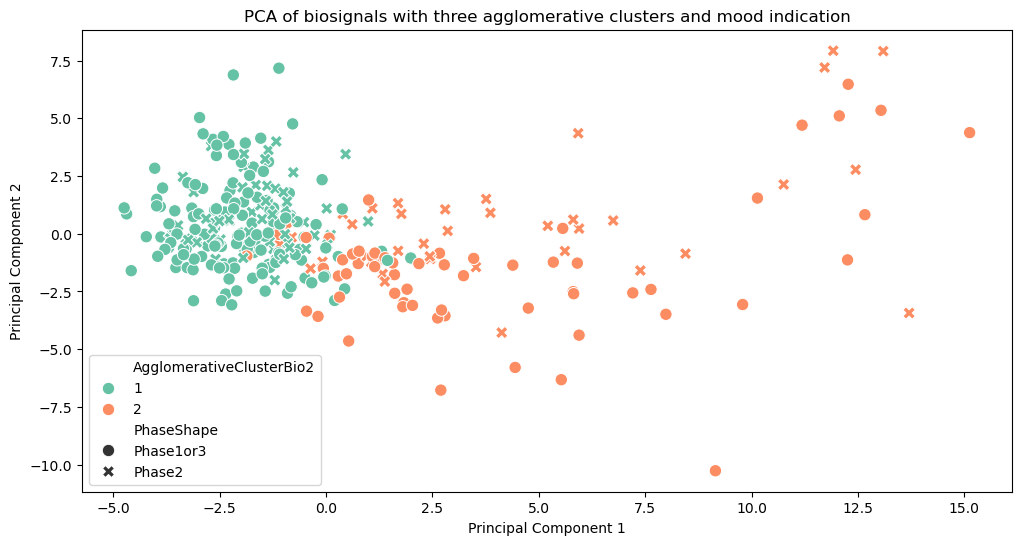

In [11]:


# --- Choose number of clusters ---
n_clusters = 2

# --- Find the appropriate height to cut the dendrogram ---
# The distance at which to cut to get `n_clusters`
cut_height = Z[-n_clusters + 1, 2]

# --- Plot dendrogram with horizontal cut line ---
plt.figure(figsize=(6, 3))
plt.title('Hierarchical Clustering Dendrogram of Biosignals')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')

dendrogram(Z, 
           truncate_mode='lastp',
           leaf_rotation=90., 
           leaf_font_size=8., 
           color_threshold=cut_height, 
           p=10)
plt.axhline(y=cut_height, c='red', linestyle='--', label=f'Cut height for {n_clusters} clusters')
plt.legend()
# Save the figure
plt.savefig('../plots/dendrogram_biosignals_2_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Optional: Cut the dendrogram to form flat clusters ---
# Here we choose to form 3 clusters (you can change 3 to another number)

cluster_labels = fcluster(Z, t=n_clusters, criterion='maxclust')

# --- Add the cluster labels back to the dataset ---
data_pd['AgglomerativeClusterBio2'] = cluster_labels

data_pd['PhaseShape'] = data_pd['Phase'].apply(lambda x: 'Phase1or3' if x in ['phase1', 'phase3'] else 'Phase2')
# Plot
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=pca_components[:, 0],
    y=pca_components[:, 1],
    hue=data_pd['AgglomerativeClusterBio2'],       # color by cluster
    #hue=data_pd['Mood'],       # color by cluster
    style=data_pd['PhaseShape'],                    # shape by phase
    palette='Set2',
    s=80                                       # optional: size of points
)
plt.title('PCA of biosignals with three agglomerative clusters and mood indication')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='')
plt.savefig('../plots/pca_biosignals_2_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_67570/2962138760.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=phase_labels, y=phase_values, ax=axes[0], palette=pairwise_colors)
/tmp/ipykernel_67570/2962138760.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_labels, y=cluster_values, ax=axes[1], palette=pairwise_colors)


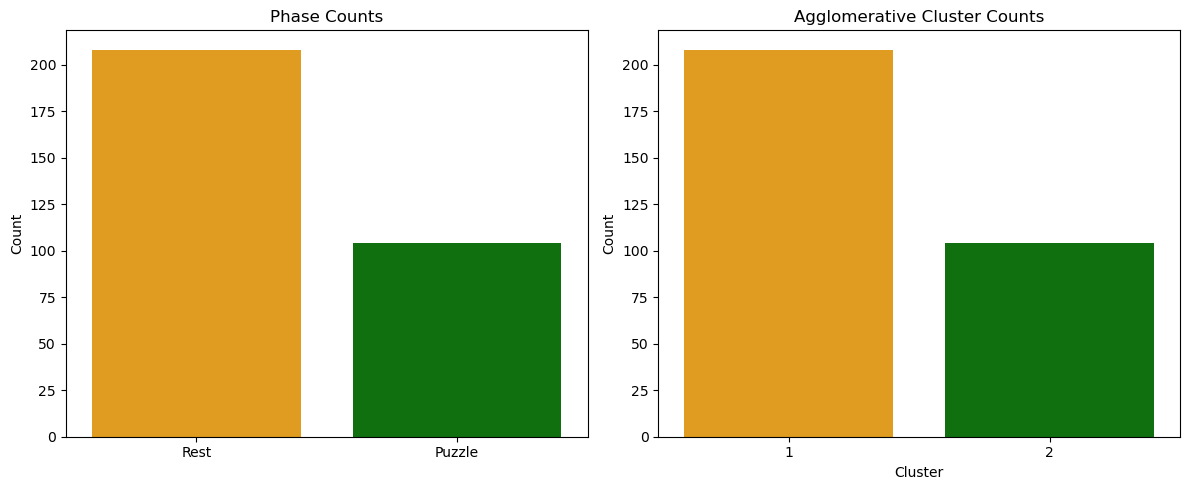

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare phase counts
phase_counts = data_pd['Phase'].value_counts()
phase1_3_count = phase_counts.get('phase1', 0) + phase_counts.get('phase3', 0)
phase2_count = phase_counts.get('phase2', 0)

phase_labels = ['Rest', 'Puzzle']
phase_values = [phase1_3_count, phase2_count]

# Prepare cluster counts
cluster_counts = data_pd['AgglomerativeClusterBio2'].value_counts()
cluster_labels = sorted(cluster_counts.index.tolist())
cluster_values = [cluster_counts.get(label, 0) for label in cluster_labels]

# Define orange and green colors
pairwise_colors = ['orange', 'green']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Phase bar plot
sns.barplot(x=phase_labels, y=phase_values, ax=axes[0], palette=pairwise_colors)
axes[0].set_title('Phase Counts')
axes[0].set_ylabel('Count')

# Cluster bar plot (will cycle orange, green, orange, green if more than two bars)
sns.barplot(x=cluster_labels, y=cluster_values, ax=axes[1], palette=pairwise_colors)
axes[1].set_title('Agglomerative Cluster Counts')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.savefig('../plots/2phase_2cluster_counts.png', dpi=300, bbox_inches='tight')
plt.show()


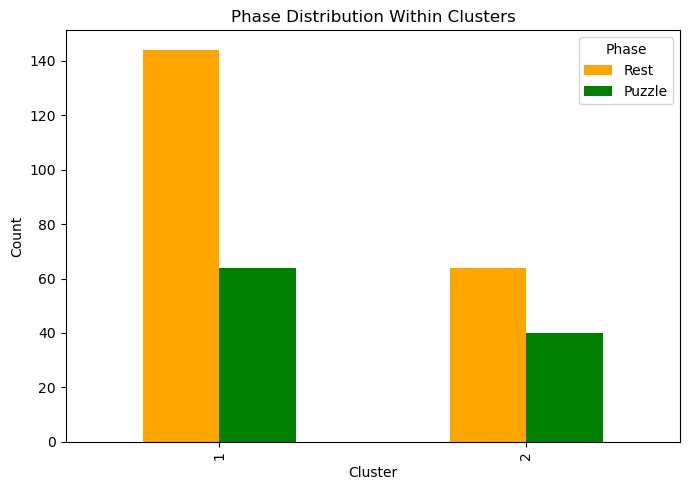

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate phase counts within each cluster
cluster_phase_counts = (
    data_pd.groupby(['AgglomerativeClusterBio2', 'Phase'])
    .size()
    .unstack(fill_value=0)
    .reindex([1, 2], fill_value=0)  # Ensure clusters 1, 2 are in order
)

# Combine phase1 + phase3 as Rest, keep phase2 as Puzzle
cluster_rest_puzzle = pd.DataFrame({
    'Rest': cluster_phase_counts.get('phase1', 0) + cluster_phase_counts.get('phase3', 0),
    'Puzzle': cluster_phase_counts.get('phase2', 0)
})

# Plot phase distribution within clusters (grouped bars)
fig, ax = plt.subplots(figsize=(7, 5))
cluster_rest_puzzle.plot(kind='bar', ax=ax, color=['orange', 'green'])

ax.set_title('Phase Distribution Within Clusters')
ax.set_xlabel('Cluster')
ax.set_ylabel('Count')
ax.legend(title='Phase')

plt.tight_layout()
plt.savefig('../plots/2phase_2cluster_within_counts.png', dpi=300, bbox_inches='tight')
plt.show()


### 4.2 hiearchcal clustering of emotions

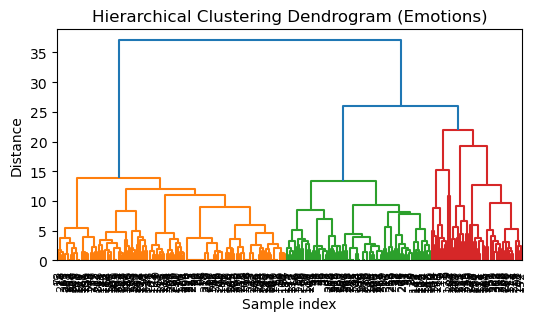

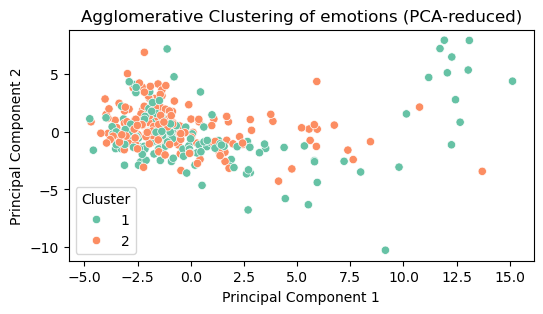

In [13]:
# --- Select only the emotion columns ---
emotion_cols = ['upset', 'hostile', 'alert', 'ashamed', 'inspired',
                'nervous', 'attentive', 'afraid', 'active', 'determined']

emotion_df = data_pd[emotion_cols]

# --- Handle missing values ---
# Drop rows with missing emotion responses
emotion_df = emotion_df.dropna()

# --- Step 4: Standardize features ---
scaler = StandardScaler()
emotion_df = scaler.fit_transform(emotion_df)

# --- Perform hierarchical clustering ---
Z_emotions = linkage(emotion_df, method='ward', metric='euclidean')

# --- Plot the dendrogram ---
plt.figure(figsize=(6, 3))
plt.title('Hierarchical Clustering Dendrogram (Emotions)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
dendrogram(Z_emotions, leaf_rotation=90., leaf_font_size=8.)
plt.show()

# --- Optional: Cut the dendrogram to form flat clusters ---
# Here we choose to form 3 clusters (you can change 3 to another number)
cluster_labels = fcluster(Z_emotions, t=2, criterion='maxclust')

# --- Add the cluster labels back to the dataset ---
data_pd['AgglomerativeCluster_emotions'] = cluster_labels


# --- (Optional) Visualize clusters using PCA ---
pca = PCA(n_components=2)
pca_components = pca.fit_transform(biometric_scaled)

plt.figure(figsize=(6, 3))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1],
                hue=cluster_labels, palette='Set2')
plt.title('Agglomerative Clustering of emotions (PCA-reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

### 4.3 K-means

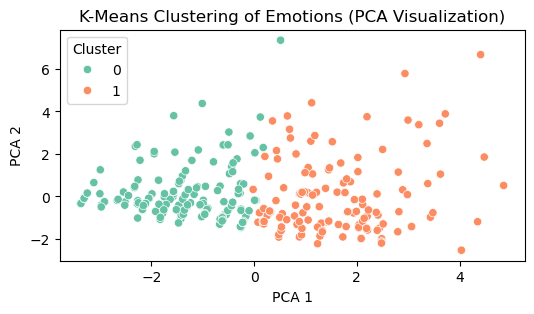

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Select emotion columns ---
emotion_cols = ['upset', 'hostile', 'alert', 'ashamed', 'inspired',
                'nervous', 'attentive', 'afraid', 'active', 'determined', 'Frustrated']

emotion_df = data_pd[emotion_cols].dropna()

# --- Step 2: Scale the emotions ---
scaler = StandardScaler()
emotion_scaled = scaler.fit_transform(emotion_df)

# --- Step 3: Run KMeans ---
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(emotion_scaled)

# --- Step 4: Add cluster labels back ---
emotion_df['EmotionCluster'] = clusters

# --- Step 5: Visualize clusters with PCA ---
pca = PCA(n_components=2)
components = pca.fit_transform(emotion_scaled)

plt.figure(figsize=(6,3))
sns.scatterplot(x=components[:,0], y=components[:,1], hue=clusters, palette='Set2')
plt.title('K-Means Clustering of Emotions (PCA Visualization)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()

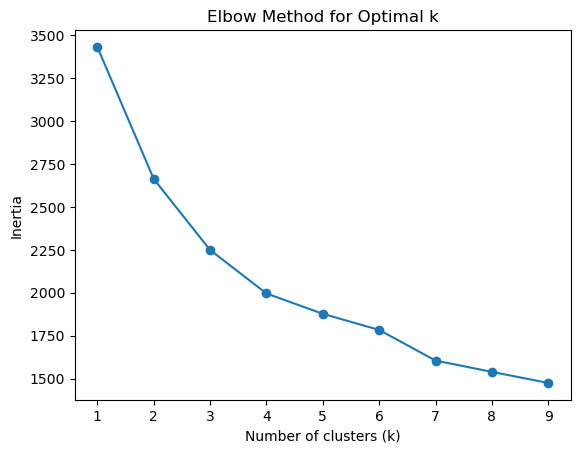

In [15]:
inertias = []
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(emotion_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()


## 5. Dimensionality reduction

### 5.1 PCA and legend defined by cohort and phase

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


# Standardize the biometric features
scaler = StandardScaler()
biometric_scaled = scaler.fit_transform(biometric_df)

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
pca_components = pca.fit_transform(biometric_scaled)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['Cohort'] = data_pd['Cohort']  # add cohort info for coloring
pca_df['Phase'] = data_pd['Phase']

# Plot
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=pca_components[:, 0],
    y=pca_components[:, 1],
    hue=data_pd['AgglomerativeClusterBio'],       # color by cluster
    style=data_pd['Cohort'],                    # shape by phase
    palette='Set2',
    s=80                                       # optional: size of points
)
plt.title('Agglomerative Clustering of Biosignals (PCA-reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster / Phase')
plt.show()

KeyError: 'AgglomerativeClusterBio'

<Figure size 1200x600 with 0 Axes>

**Oberservations**: It seems like the D1_2 cohort is not the in the same cluster as the other cohorts. THe D1_2 cohort was conducted in the fall in one session

### 5.2 Non Negative matrix facorization **NMF**


#### 5.2.1 NMF on emotion data

In [ ]:
emotion_cols = ['upset', 'hostile', 'alert', 'ashamed', 'inspired',
                'nervous', 'attentive', 'afraid', 'active', 'determined']
emotion_data = data_pd[emotion_cols]

In [ ]:
from sklearn.decomposition import NMF

# Choose number of components (how many "emotion profiles" you want)
n_components = 2

# Create NMF model
nmf_model = NMF(n_components=n_components, init='random', random_state=42)

# Fit and transform
W = nmf_model.fit_transform(emotion_data)
H = nmf_model.components_


/home/aws/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


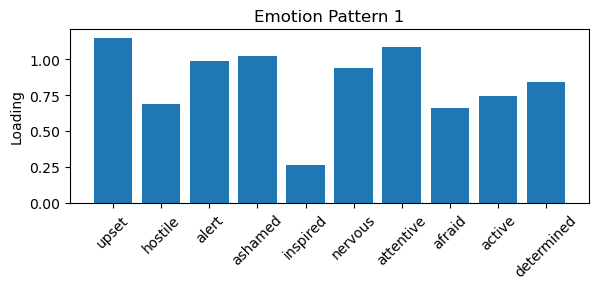

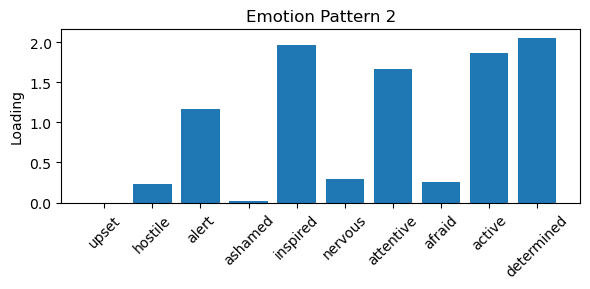

In [ ]:
import matplotlib.pyplot as plt

# Plot component loadings
for i, component in enumerate(H):
    plt.figure(figsize=(6, 3))
    plt.bar(emotion_cols, component)
    plt.title(f'Emotion Pattern {i+1}')
    plt.xticks(rotation=45)
    plt.ylabel('Loading')
    plt.tight_layout()
    plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# W and H matrices after NMF
W_df = pd.DataFrame(W, columns=[f'Pattern_{i+1}' for i in range(W.shape[1])])
H_df = pd.DataFrame(H, columns=emotion_cols, index=[f'Pattern_{i+1}' for i in range(H.shape[0])])

# Heatmap of H (Emotion Loadings)
#plt.figure(figsize=(10, 6))
#sns.heatmap(H_df, annot=True, cmap='viridis')
#plt.title('Emotion Loadings (H matrix)')
#plt.xlabel('Emotion')
#plt.ylabel('Pattern')
#plt.show()
#
## (Optional) Heatmap of W (Participant Scores)
## Select a sample if you have too many participants
#plt.figure(figsize=(6, 3))
#sns.heatmap(W_df.iloc[:50], cmap='coolwarm')
#plt.title('Participant Pattern Scores (W matrix)')
#plt.xlabel('Pattern')
#plt.ylabel('Participant')
#plt.show()


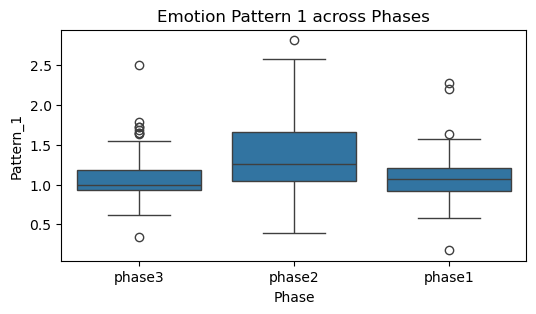

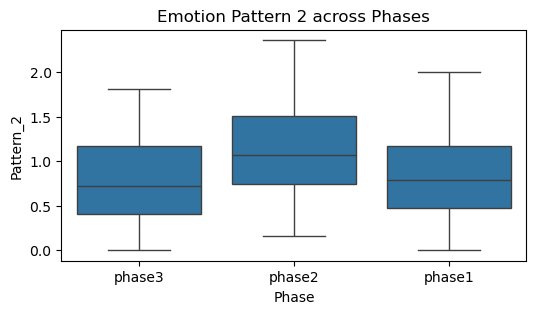

In [ ]:
# Turn W matrix into a DataFrame
W_df = pd.DataFrame(W, columns=['Pattern_1', 'Pattern_2'])

# Join with original data to bring in 'Phase'
W_df['Phase'] = data_pd['Phase'].values

import seaborn as sns
import matplotlib.pyplot as plt

# Plot Pattern 1
plt.figure(figsize=(6, 3))
sns.boxplot(x='Phase', y='Pattern_1', data=W_df)
plt.title('Emotion Pattern 1 across Phases')
plt.show()

# Plot Pattern 2
plt.figure(figsize=(6, 3))
sns.boxplot(x='Phase', y='Pattern_2', data=W_df)
plt.title('Emotion Pattern 2 across Phases')
plt.show()


In [ ]:
from scipy.stats import f_oneway

# One-way ANOVA for Pattern 1
groups = [group['Pattern_1'] for name, group in W_df.groupby('Phase')]
f_stat, p_val = f_oneway(*groups)
print(f'Pattern 1 ANOVA: F={f_stat:.2f}, p={p_val:.4f}')


Pattern 1 ANOVA: F=18.83, p=0.0000


**Conconclusion**:
Using NMF, we extracted two distinct emotional patterns. ANOVA results show that Pattern 1 scores differ significantly across phases, particularly in the active phase.
This suggests that Pattern 1 may represent a low-dimensional emotional state characteristic of the active phase, capturing a dominant affective profile during that period. 

## 6. Supervised 

This supervised versions encodes individuals with a y = 1 or 0 classifier according to the overall score of the postive and negative emotioons on the queationarie

- y = 1 if the mean of the postive emotions is greater than that of the negative emotions
- y = 0 vice versa

### 6.1 Model using a Logistic regression with L2 penalty

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X = biometric_df
# Define the columns
positive_emotions = ['active', 'alert', 'attentive', 'determined', 'inspired']
negative_emotions = ['afraid', 'ashamed', 'hostile', 'nervous', 'upset']

# Calculate the mean of positive and negative emotions for each row
positive_mean = emotions_df_scaled[positive_emotions].mean(axis=1)
negative_mean = emotions_df_scaled[negative_emotions].mean(axis=1)

# Create the target vector y
y = (positive_mean > negative_mean).astype(int) 

# --- Step 4: Standardize features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Assume X and y are already prepared
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train logistic regression with regularization
logreg = LogisticRegression(penalty='l2', solver='liblinear', C=1.0, class_weight='balanced', random_state=42)
logreg.fit(X_train, y_train)

# Predict and evaluate
y_pred = logreg.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.2f}")


Confusion Matrix:
[[27 29]
 [18 20]]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.48      0.53        56
           1       0.41      0.53      0.46        38

    accuracy                           0.50        94
   macro avg       0.50      0.50      0.50        94
weighted avg       0.52      0.50      0.50        94


Accuracy: 0.50


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Prepare target vector
positive_emotions = ['active', 'alert', 'attentive', 'determined', 'inspired']
negative_emotions = ['afraid', 'ashamed', 'hostile', 'nervous', 'upset']

positive_mean = emotions_df[positive_emotions].mean(axis=1)
negative_mean = emotions_df[negative_emotions].mean(axis=1)
y = (positive_mean > negative_mean).astype(int)

# Scale biometric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(biometric_df)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# List of models to evaluate
models = {
    "Logistic Regression": LogisticRegression(penalty='l2', solver='liblinear', C=1.0, class_weight='balanced', random_state=42),
    "LDA": LDA(),
    "MLP (ANN)": MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42),
    "SVM": SVC(kernel='rbf', class_weight='balanced', random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
}

# Evaluate each model
for name, model in models.items():
    print(f"\n--- {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")



--- Logistic Regression ---
Confusion Matrix:
[[ 7  8]
 [15 64]]
Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.47      0.38        15
           1       0.89      0.81      0.85        79

    accuracy                           0.76        94
   macro avg       0.60      0.64      0.61        94
weighted avg       0.80      0.76      0.77        94

Accuracy: 0.76

--- LDA ---
Confusion Matrix:
[[ 2 13]
 [ 1 78]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.13      0.22        15
           1       0.86      0.99      0.92        79

    accuracy                           0.85        94
   macro avg       0.76      0.56      0.57        94
weighted avg       0.83      0.85      0.81        94

Accuracy: 0.85

--- MLP (ANN) ---
Confusion Matrix:
[[ 0 15]
 [ 1 78]]
Classification Report:
              precision    recall  f1-score   support

           0       0

/home/aws/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aws/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aws/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
